<a href="https://colab.research.google.com/github/senthilkumar-dimitra/LULC-Classification-DL/blob/expts/LULC_Classification_using_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount GDRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages
!pip install rasterio -q
!pip install earthpy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.9 MB/s eta 0:00:00


In [3]:
# Import packages
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import rasterio
import earthpy.plot as ep
from matplotlib.colors import from_levels_and_colors
import ee

In [4]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='senthilkumar-dimitra')

In [5]:
# Parameters
FEATURES = ['VV', 'VH','B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9','B11', 'B12', 'ndvi', 'ndbi', 'mndwi', 'ndwi', 'bsi', 'evi', 'elev']
LABEL = ['class']
SPLIT = ['sample']
N_CLASSES = 6
CLASSES = [0, 1, 2, 3, 4, 5]
PALETTE = ['006400', 'f096ff', '42c447', 'ffff4c', '0064c8','835313']
SAMPLE_PATH = '/content/drive/MyDrive/DL_LULC_Jambi_new/Samples_LC_Jambi_2023.csv'
IMAGE_PATH = '/content/drive/MyDrive/DL_LULC_Jambi_new/S1S2_Jambi_2023.tif'


In [6]:
# Load image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)


In [7]:
# Read sample
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac = 1) # Shuffle data


In [8]:
samples

,VV,VH,B1,B2,B3,B4,B5,B6,B7,B8,...,ndvi,ndbi,mndwi,ndwi,bsi,evi,elev,slope,class,sample
435,-8.131410,-13.978124,649.500000,626.0,806.5,680.5,1297.500000,2977.0,3597.50,3516.000000,...,0.675682,-0.117166,-0.550070,-0.626836,-0.089857,2.440189,52,9.059016,0,train
6502,-7.388585,-15.744801,568.000000,500.0,665.0,452.0,972.000000,2717.0,3478.00,3309.000000,...,0.759638,-0.271714,-0.480469,-0.665325,-0.237492,3.143706,78,2.073277,3,train
1087,-6.698078,-13.534704,505.000000,400.0,497.5,318.5,737.500000,2191.5,2838.00,2759.500000,...,0.793047,-0.317184,-0.483921,-0.694504,-0.287359,3.650912,107,2.781794,0,train
4141,-12.074733,-17.828283,1282.000000,1511.0,2054.0,2638.0,3278.500000,3796.0,4083.50,3861.000000,...,0.188183,0.076813,-0.373542,-0.305495,0.141407,0.365839,115,5.847403,1,train
4481,-9.768532,-16.228205,1014.500000,1057.5,1429.0,1620.5,1859.500000,2641.0,2944.00,2834.000000,...,0.272421,-0.000706,-0.328950,-0.329580,0.067010,0.655698,98,3.341118,1,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,-7.659558,-14.309342,614.000000,578.0,941.0,925.0,1409.000000,2786.0,3229.00,3204.000000,...,0.551950,-0.036725,-0.519653,-0.545959,0.015617,1.289027,63,2.930605,1,train
3536,-7.755516,-15.346207,791.000000,681.0,959.0,815.0,1255.000000,3185.0,3915.00,3769.000000,...,0.644415,-0.129458,-0.503623,-0.594332,-0.089351,2.078818,59,4.141147,1,train
1062,-8.746043,-14.791394,453.769231,458.0,641.0,362.0,856.571429,2868.0,3665.75,3693.166667,...,0.821462,-0.353263,-0.467165,-0.704211,-0.322414,3.425482,95,10.694665,0,train
1024,-6.897036,-13.953484,446.500000,428.5,607.0,319.5,898.000000,2918.0,3658.00,3626.500000,...,0.838064,-0.346764,-0.486898,-0.713240,-0.322247,3.547141,106,3.929904,0,train


In [9]:
class_counts = samples['class'].value_counts()
total_rows = samples.shape[0]

for class_label, count in class_counts.items():
  print(f"Class {class_label}: {count}")

print(f"Total rows: {total_rows}")

Class 0: 3339
Class 3: 1743
Class 1: 1670
Class 2: 627
Class 4: 375
Class 5: 277
Total rows: 8031


In [13]:
# Split into train and test based on column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

# Convert samples dataframe (pandas) to numpy array
train_input = train_features.to_numpy()
test_input = test_features.to_numpy()

# Make label data categorical
train_output = to_categorical(train_label.to_numpy(), N_CLASSES)
test_output = to_categorical(test_label.to_numpy(), N_CLASSES)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')


Train features: (7162, 21)
Test features: (869, 21)
Train label: (7162, 6)
Test label: (869, 6)


In [14]:
# Create MLP model
model = Sequential([
    Dense(256, activation='relu', input_shape=(len(FEATURES),)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(N_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5632      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 3

In [15]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [16]:
# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=32,
    callbacks=[stop],
    epochs=100,
)

Epoch 1/100
224/224 [==============================] - 5s 7ms/step - loss: 62.9292 - accuracy: 0.4282 - val_loss: 2.0268 - val_accuracy: 0.5386
Epoch 2/100
224/224 [==============================] - 1s 4ms/step - loss: 4.7430 - accuracy: 0.4676 - val_loss: 1.6671 - val_accuracy: 0.3544
Epoch 3/100
224/224 [==============================] - 1s 4ms/step - loss: 1.7360 - accuracy: 0.4705 - val_loss: 1.5939 - val_accuracy: 0.3544
Epoch 4/100
224/224 [==============================] - 1s 4ms/step - loss: 1.5369 - accuracy: 0.4726 - val_loss: 1.5753 - val_accuracy: 0.3544
Epoch 5/100
224/224 [==============================] - 1s 4ms/step - loss: 1.4434 - accuracy: 0.4703 - val_loss: 1.5747 - val_accuracy: 0.3544
Epoch 6/100
224/224 [==============================] - 1s 4ms/step - loss: 1.3849 - accuracy: 0.4719 - val_loss: 1.5715 - val_accuracy: 0.3544
Epoch 7/100
224/224 [==============================] - 1s 4ms/step - loss: 1.3560 - accuracy: 0.4711 - val_loss: 1.5662 - val_accuracy: 0.354

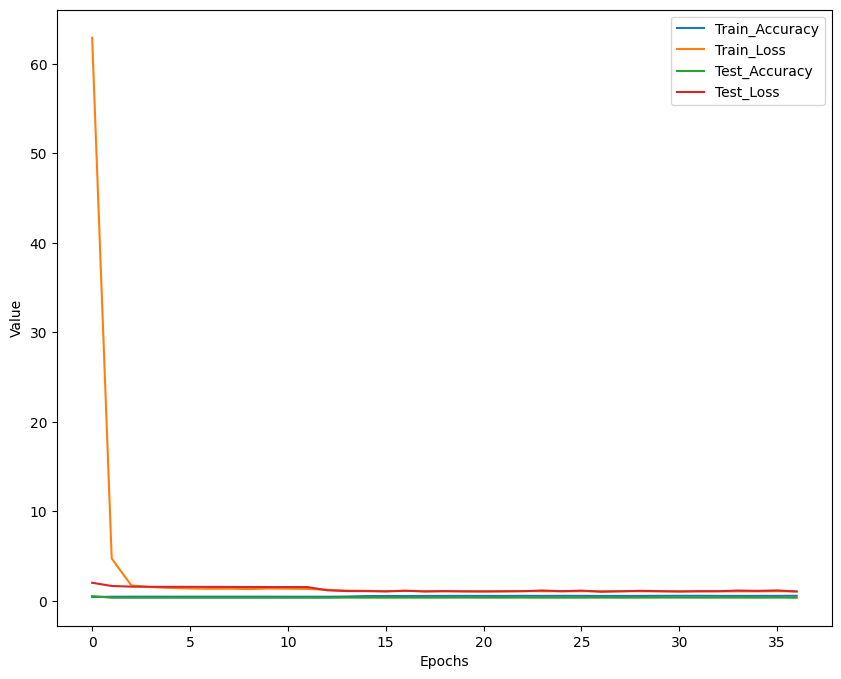

In [17]:
# Show history
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(history['accuracy'], label = 'Train_Accuracy')
plt.plot(history['loss'], label = 'Train_Loss')
plt.plot(history['val_accuracy'], label = 'Test_Accuracy')
plt.plot(history['val_loss'], label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

In [18]:
# Predict test data
prediction = np.argmax(model.predict(test_input), 1)
label = np.argmax(test_output, 1)

# Confusion matrix
cm = confusion_matrix(label, prediction)
print("Confusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(label, prediction))


28/28 [==============================] - 0s 4ms/step
Confusion Matrix:
[[298   0   0   0   0   0]
 [  3  15   0   0   0   0]
 [  0 134   0   0   0   0]
 [388   0   0   0   0   0]
 [  0   0   1   0   9   0]
 [  0  21   0   0   0   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.43      1.00      0.60       298
           1       0.09      0.83      0.16        18
           2       0.00      0.00      0.00       134
           3       0.00      0.00      0.00       388
           4       1.00      0.90      0.95        10
           5       0.00      0.00      0.00        21

    accuracy                           0.37       869
   macro avg       0.25      0.46      0.29       869
weighted avg       0.16      0.37      0.22       869



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# Calculate Producer's Accuracy, User's Accuracy, and Kappa Coefficient using Earth Engine
def calculate_accuracy_metrics(actual, predicted):
    confusion_matrix = ee.ConfusionMatrix(actual, predicted)

    # Producer's Accuracy
    producers_accuracy = confusion_matrix.producersAccuracy()

    # User's Accuracy
    users_accuracy = confusion_matrix.consumersAccuracy()

    # Overall Accuracy
    overall_accuracy = confusion_matrix.accuracy()

    # Kappa Coefficient
    kappa = confusion_matrix.kappa()

    return producers_accuracy, users_accuracy, overall_accuracy, kappa

# Convert numpy arrays to Earth Engine arrays
actual_ee = ee.Array(label.tolist())
predicted_ee = ee.Array(prediction.tolist())

# Calculate metrics
producers_acc, users_acc, overall_acc, kappa = calculate_accuracy_metrics(actual_ee, predicted_ee)

print("\nEarth Engine Accuracy Metrics:")
print(f"Producer's Accuracy: {producers_acc.getInfo()}")
print(f"User's Accuracy: {users_acc.getInfo()}")
print(f"Overall Accuracy: {overall_acc.getInfo()}")
print(f"Kappa Coefficient: {kappa.getInfo()}")



Earth Engine Accuracy Metrics:


EEException: ConfusionMatrix, argument 'order': Invalid type.
Expected type: List<Integer>.
Actual type: Short<0, 255, dimensions=1>.
Actual value: [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 4, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [20]:
# Predict image using the model
image_input = []
for x in range(14):
    image_input.append(image.read(x + 1))
image_input = np.stack(image_input).reshape(14, -1).T

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=(10, 10))
plt.show()


InvalidArgumentError: Graph execution error:

Detected at node sequential/dense/MatMul defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-20-2268836989b7>", line 8, in <cell line: 8>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2655, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py", line 241, in call

Matrix size-incompatible: In[0]: [81920,14], In[1]: [21,256]
	 [[{{node sequential/dense/MatMul}}]] [Op:__inference_predict_function_40602]

In [ ]:
# Save file to drive
save_location = '/content/drive/MyDrive/DL_LULC_Jambi_new/'
name = 'LC_Jambi_2023_MLP.tif'
location = save_location + name

new_dataset = rasterio.open(
    location,
    mode='w', driver='GTiff',
    height = prediction.shape[0], width = prediction.shape[1],
    count=1, dtype=str(prediction.dtype),
    crs=crs,
    transform=transform
)
new_dataset.write(prediction, 1)
new_dataset.close()